In [ ]:
# blood_analyzer.py 모듈 전체 코드 인라인 삽입
"""
Blood Analyzer Code Extraction Utilities

이 모듈은 혈액 분석기 관련 데이터에서 코드를 추출하는 유틸리티 함수들을 제공합니다.
"""

from typing import Set, List
from app.services.analysis.reference.analyzers import ANALYZERS
from app.services.analysis.reference.reference_data import REFERENCE_TESTS

def extract_analyzer_codes() -> Set[str]:
    """
    ANALYZERS에서 모든 test code를 추출합니다.
    Returns:
        Set[str]: 분석기에서 추출된 모든 unique test code들
    """
    codes = set()
    for manufacturer, models in ANALYZERS.items():
        for model_name, model_data in models.items():
            tests = model_data.get("tests", [])
            for test in tests:
                if "code" in test:
                    codes.add(test["code"])
    return codes

def extract_reference_codes() -> Set[str]:
    """
    REFERENCE_TESTS에서 모든 code를 추출합니다.
    Returns:
        Set[str]: 레퍼런스 데이터에서 추출된 모든 unique code들
    """
    codes: Set[str] = set()
    for item in REFERENCE_TESTS:
        if isinstance(item, dict) and "code" in item:
            codes.add(item["code"])
    return codes

def extract_all_unique_codes() -> List[str]:
    """
    ANALYZERS와 SUBPARAMETERS의 모든 코드를 합쳐서 unique한 코드들을 반환합니다.
    Returns:
        List[str]: 알파벳 순으로 정렬된 모든 unique code들
    """
    analyzer_codes = extract_analyzer_codes()
    reference_codes = extract_reference_codes()
    return sorted(analyzer_codes | reference_codes)

def get_analyzer_codes_by_manufacturer(manufacturer: str) -> Set[str]:
    """
    특정 제조사의 분석기에서 코드들을 추출합니다.
    Args:
        manufacturer (str): 제조사 이름 (예: "Abaxis", "IDEXX")
    Returns:
        Set[str]: 해당 제조사 분석기의 모든 unique test code들
    """
    codes = set()
    if manufacturer in ANALYZERS:
        for model_name, model_data in ANALYZERS[manufacturer].items():
            tests = model_data.get("tests", [])
            for test in tests:
                if "code" in test:
                    codes.add(test["code"])
    return codes

def get_analyzer_codes_by_model(manufacturer: str, model: str) -> Set[str]:
    """
    특정 제조사의 특정 모델에서 코드들을 추출합니다.
    Args:
        manufacturer (str): 제조사 이름
        model (str): 모델 이름
    Returns:
        Set[str]: 해당 모델의 모든 test code들
    """
    codes = set()
    if manufacturer in ANALYZERS and model in ANALYZERS[manufacturer]:
        tests = ANALYZERS[manufacturer][model].get("tests", [])
        for test in tests:
            if "code" in test:
                codes.add(test["code"])
    return codes

def get_reference_codes_by_prefix(prefix: str) -> Set[str]:
    """
    특정 접두사로 시작하는 레퍼런스 코드들을 추출합니다.
    Args:
        prefix (str): 코드 접두사 (예: "AL", "BUN", "pH")
    Returns:
        Set[str]: 조건에 맞는 code들
    """
    codes: Set[str] = set()
    p = prefix.upper()
    for item in REFERENCE_TESTS:
        if isinstance(item, dict):
            c = str(item.get("code", ""))
            if c.upper().startswith(p):
                codes.add(c)
    return codes

def get_code_statistics() -> dict:
    """
    코드 추출 통계 정보를 반환합니다.
    Returns:
        dict: 통계 정보를 담은 딕셔너리
    """
    analyzer_codes = extract_analyzer_codes()
    reference_codes = extract_reference_codes()
    all_codes = analyzer_codes | reference_codes
    common_codes = analyzer_codes & reference_codes
    return {
        "analyzer_codes_count": len(analyzer_codes),
        "reference_codes_count": len(reference_codes),
        "total_unique_codes_count": len(all_codes),
        "common_codes_count": len(common_codes),
        "analyzer_only_count": len(analyzer_codes - reference_codes),
        "reference_only_count": len(reference_codes - analyzer_codes),
        "common_codes": sorted(common_codes)
    }

def search_code_in_data(search_code: str) -> dict:
    """
    특정 코드가 어디에서 사용되는지 검색합니다.
    Args:
        search_code (str): 검색할 코드
    Returns:
        dict: 검색 결과를 담은 딕셔너리
    """
    result = {
        "code": search_code,
        "found_in_analyzers": [],
        "found_in_subparameters": []
    }
    # ANALYZERS에서 검색
    for manufacturer, models in ANALYZERS.items():
        for model_name, model_data in models.items():
            tests = model_data.get("tests", [])
            for test in tests:
                if test.get("code") == search_code:
                    result["found_in_analyzers"].append({
                        "manufacturer": manufacturer,
                        "model": model_name,
                        "test_info": test
                    })
    # REFERENCE_TESTS에서 검색
    for item in REFERENCE_TESTS:
        if isinstance(item, dict) and item.get("code") == search_code:
            result["found_in_subparameters"].append({
                "category": item.get("sample_type"),
                "item_info": item
            })
    return result


In [174]:
import os
import base64
import json
import io
import sys
from typing import List, Dict, Any, Tuple, Callable, Sequence, Optional

# 외부 라이브러리
import numpy as np
import cv2
import fitz
from PIL import Image, ImageFilter, ImageOps
from pytesseract import image_to_data, Output
from dotenv import load_dotenv
from openai import OpenAI
import matplotlib.pyplot as plt

# 프로젝트 루트 경로를 Python path에 추가
project_root = os.path.abspath('/home/aidan/work/meow-chat')
if project_root not in sys.path:
    sys.path.append(project_root)

# 이제 app.services.analysis.image_preprocessing를 import
try:
    from app.services.analysis.image_preprocessing import (
        # 공통 함수들
        pdf_to_images, open_with_exif, save_png_bytes, apply_pipeline,
        
        # 전처리 함수들
        flatten_transparency, auto_crop_with_margin, normalize_mode,
        upscale_min_resolution, illumination_flatten, suppress_glare,
        weak_autocontrast, apply_clahe, conservative_sharpen, blacken_reddish_text, blacken_bluish_text, to_grayscale,
        adaptive_binarize_for_ocr, enhance_table_lines, table_smart_crop,
        add_white_border, downscale_target_long_edge, ocr_quality_gate,
        
        # 고급 전처리 함수들 (필요시)
        detect_document_quad, perspective_unwarp, deskew_textlines,
        conditional_dewarp
    )
    print("✅ 이미지 전처리 함수들 import 완료!")
except ImportError as e:
    print(f"❌ Import 오류: {e}")
    print("📂 현재 sys.path:", sys.path[-3:])

print("📦 라이브러리 로드 완료!")

✅ 이미지 전처리 함수들 import 완료!
📦 라이브러리 로드 완료!


In [175]:
# 환경변수 로드 (.env 파일은 프로젝트 루트에 위치)
load_dotenv()  # 현재 디렉토리와 상위 디렉토리에서 자동으로 .env 파일을 찾음

# OpenAI 클라이언트 초기화
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 환경 확인
print(f"🔑 API Key 설정: {'✅ 완료' if os.getenv('OPENAI_API_KEY') else '❌ 없음'}")
print(f"📂 현재 경로: {os.getcwd()}")
print(f"📄 PDF 파일 존재: {'✅ 있음' if os.path.exists('../../test/data/은내과.pdf') else '❌ 없음'}")

🔑 API Key 설정: ✅ 완료
📂 현재 경로: /home/aidan/work/meow-chat
📄 PDF 파일 존재: ❌ 없음


In [176]:
# img_path = os.path.abspath('notebooks/ocr/assets/images/test_image_1.jpg')

# img_path = os.path.abspath('notebooks/ocr/assets/images/20241106.jpg')   # ---------- 날짜가 여러개
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241107_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241107.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241121_2.png')  # ---------- 날짜 없는것
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241121.png')    # ---------- 사진으로 짝어서 삐뚤어진것
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241123_2.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241123.png')    # ---------- 인쇄일자만 있음
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241205_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241205.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241219.png')    # ---------- 사진으로 짝어서 삐뚤어진것
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241221_2.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241221.jpg')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241224_2.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241224.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20241231.png')
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250107.png')    # ----------
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250110.png')    # ---------- 데이블 구조 특이한것. value 열 레이블이 날짜임
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_2.png')  
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_3.png')  # ---------- blue 글자 인식이 잘 안됨
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116_4.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250116.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119_2.png')  # ---------- 흐릿한 이미지
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119_3.png') 
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250119.png')    # ---------- 흐릿한 이미지
img_path = os.path.abspath('notebooks/ocr/assets/images/20250125.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류 RDW-CV  RETIC#
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250203.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250207.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250209.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250216.jpeg') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250222.png') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250228.png') # ----------   A4 지 1장 이상 분량은 대량 오류
# img_path = os.path.abspath('notebooks/ocr/assets/images/20250301.png')



# img_path = os.path.abspath('notebooks/ocr/assets/images/20250125.jpeg')



print(f"분석할 이미지: {img_path}")    

분석할 이미지: /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20241121.png


In [177]:
def preprocess(
    img_bytes: bytes,    
    debug: bool = True,
) -> bytes:
    try:
        if debug:
            print("🏥 의료 문서용 전처리 시작")
        
        img = open_with_exif(img_bytes) # EXIF 회전 교정
        original_size = img.size
        
        if debug:
            print(f"📏 원본 이미지 크기: {original_size}")
        
        steps = [
            # 기본 정리 (필수 선행 단계)
            (flatten_transparency, {}),              # 투명도 제거
            (normalize_mode, {}),                    # 모드 표준화 (L/RGB)
            
            # 기하학적 보정 (픽셀 수준 작업)
            # (auto_crop_with_margin, {}),           # 여백 제거
            (conditional_dewarp, {}),                # 페이지 휘어짐 보정 
            (deskew_textlines, {}),                # 미세 기울기 보정
          
            # 해상도 표준화 (최소 품질 확보)
            (upscale_min_resolution, {}),            
            
            # 빛반사 제거
            (suppress_glare, {}),                   
            
            # 대비 향상
            (weak_autocontrast, {}),               
            
            # 색 텍스트 보정(있으면)
            (blacken_reddish_text, {}),  
            (blacken_bluish_text, {}), 

            # 회색화
            (to_grayscale, {}),                   

            # 표 라인 강화
            (enhance_table_lines, {}), 
            
            # 최종 크기 조정 (토큰 절약)
            (downscale_target_long_edge, {}),      

            # 선명도 향상
            (conservative_sharpen, {}),           
        ]
    
        # 파이프라인 실행
        img = apply_pipeline(img, steps)
        
        # PNG로 저장
        buf = io.BytesIO()
        if img.mode == 'L':  # 그레이스케일
            img.save(buf, format="JPEG", quality=85, optimize=True)
        else:  # RGB
            img.save(buf, format="JPEG", quality=85, optimize=True, subsampling=2)
        result_bytes = buf.getvalue()
        
        if debug:
            final_size = img.size
            print(f"📐 최종 이미지 크기: {final_size}")
            print(f"🔄 크기 변화: {original_size} → {final_size}")
            # 용량 변화 및 퍼센트 계산
            original_bytes = len(img_bytes)
            result_bytes_len = len(result_bytes)
            percentage = (result_bytes_len / original_bytes) * 100
            
            print(f"💾 용량 변화: {original_bytes:,} bytes → {result_bytes_len:,} bytes ({percentage:.1f}%)")
            print("✅ 전처리 완료")
        
        return result_bytes
        
    except Exception as e:
        if debug:
            print(f"❌ 전처리 실패: {e}")
            import traceback
            traceback.print_exc()
        
        print(f"⚠️ 전처리 실패, 원본 반환: {e}")
        return img_bytes 

In [178]:
def image_to_base64(image_data: bytes) -> str:
    """이미지를 base64로 인코딩"""
    return base64.b64encode(image_data).decode('utf-8')

def analyze_medical_document_with_gpt4v(image_data: bytes, page_num: int = 0) -> dict:
    """GPT-4V로 혈액검사 데이터 추출 및 JSON 반환"""

    base64_image = image_to_base64(image_data)

    system_prompt = """
    당신은 이미지를 분석하여 표의 데이터를 JSON 형식으로 추출하는 역할을 합니다.
    표의 구조와 셀 경계를 시각적으로 인식하고, 아래의 모든 규칙을 절대적으로 따르세요.

    ---

    📌 출력 형식
    {
    "tests": [
        {
        "code": "string",
        "value": "string",
        "reference_min": "string",
        "reference_max": "string",
        "unit": "string"
        }
    ]
    }

    ---

    📋 필수 규칙

    1️⃣ [표 구조 유지]
    - 표의 열 순서는 항상 다음과 같아야 합니다:
    **Name → Unit → Min → Max → Result**
    - 어떤 행에서도 열 순서가 바뀌거나 누락되어서는 안 됩니다.
    - 각 행은 반드시 다섯 개의 셀을 유지해야 합니다.

    2️⃣ [빈 셀 처리]
    - 셀에 값이 없거나 글자가 희미하여 인식되지 않더라도,
    그 셀은 존재합니다.
    - 그런 셀은 반드시 `"UNKNOWN"` 으로 채웁니다.
    - 주변 셀의 값을 끌어오거나 합치지 마세요.
    - 공백이나 비어 있음("") 대신 항상 `"UNKNOWN"` 을 사용합니다.

    3️⃣ [추정 금지]
    - 수치를 추정하거나 보정하지 마세요.
    - 표의 간격, 정렬, 위치 등을 근거로 값을 채우지 않습니다.
    - “누락된 것처럼 보인다”는 이유로 주변 숫자를 넣지 않습니다.

    4️⃣ [셀 경계 인식]
    - 각 셀은 시각적으로 박스로 구분되어 있다고 가정합니다.
    - 셀의 경계선이 희미해도 행과 열 구조를 유지해야 합니다.
    - 셀 간 간격이 넓어도 같은 행이라면 반드시 하나의 객체로 묶습니다.

    5️⃣ [단위와 숫자 구분]
    - 단위(Unit)은 원문 그대로 보존합니다. (예: g/dL, %, mmol/L)
    - 퍼센트는 "%"로만 남기며 다른 기호를 추가하지 않습니다.
    - 숫자나 소수점이 있더라도 따옴표로 감싸 문자열로 표시합니다.

    6️⃣ [JSON 형식 고정]
    - `"tests"` 배열만 출력합니다.
    - 다른 키, 설명, 텍스트, 해설을 추가하지 않습니다.
    - 모든 항목이 문자열이어야 하며, 빈칸은 `"UNKNOWN"` 으로 표시합니다.

    ---

    🧠 추가 지침
    - 좌우 간격으로 값을 추정하지 않습니다.
    - 같은 행에 여러 숫자가 있어도, 열 구조를 기준으로 구분해야 합니다.
    - 비어 있는 셀은 데이터 누락이 아니라 **정상적인 셀**로 취급해야 합니다.

    ---

    📘 출력 예시

    {
    "tests": [
        {
        "code": "RETIC%",
        "value": "UNKNOWN",
        "reference_min": "UNKNOWN",
        "reference_max": "UNKNOWN",
        "unit": "%"
        },
        {
        "code": "WBC",
        "value": "27.38",
        "reference_min": "2.87",
        "reference_max": "17.02",
        "unit": "10³/µL"
        }
    ]
    }

    """

    user_prompt = """
    이미지를 읽고 위 지침을 적용하여 스키마대로 JSON만 반환하세요.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": user_prompt},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}",
                                "detail": "high"
                            }
                        }
                    ]
                }
            ],
            temperature=0,
            response_format={"type": "json_object"} 
        )
        
        # JSON 파싱
        result_text = response.choices[0].message.content
        
        if "```json" in result_text:
            json_start = result_text.find("```json") + 7
            json_end = result_text.find("```", json_start)
            json_text = result_text[json_start:json_end].strip()
        else:
            json_text = result_text
        
        parsed_result = json.loads(json_text)
        return parsed_result
            
    except Exception as e:
        print(f"❌ GPT-4V 분석 오류: {e}")
        return {
            "inspection_date": "Error",
            "tests": []
        }

print("🧠 GPT-4V 분석 함수 정의 완료!")

🧠 GPT-4V 분석 함수 정의 완료!


📷 이미지 파일 로드 중: /home/aidan/work/meow-chat/notebooks/ocr/assets/images/20241121.png

🔧 전처리 시작...
🏥 의료 문서용 전처리 시작
📏 원본 이미지 크기: (1179, 1568)
[conditional_dewarp] r2_lin=0.007, r2_quad=0.019, gain=0.011, amp=373.51px
[conditional_dewarp] 곡률/적합 품질 부족 - 스킵
[deskew_textlines] Hough angle: 0.00°
[deskew_textlines] coarse=0.00°, final=0.85°
📐 최종 이미지 크기: (1353, 1800)
🔄 크기 변화: (1179, 1568) → (1353, 1800)
💾 용량 변화: 2,424,766 bytes → 675,724 bytes (27.9%)
✅ 전처리 완료


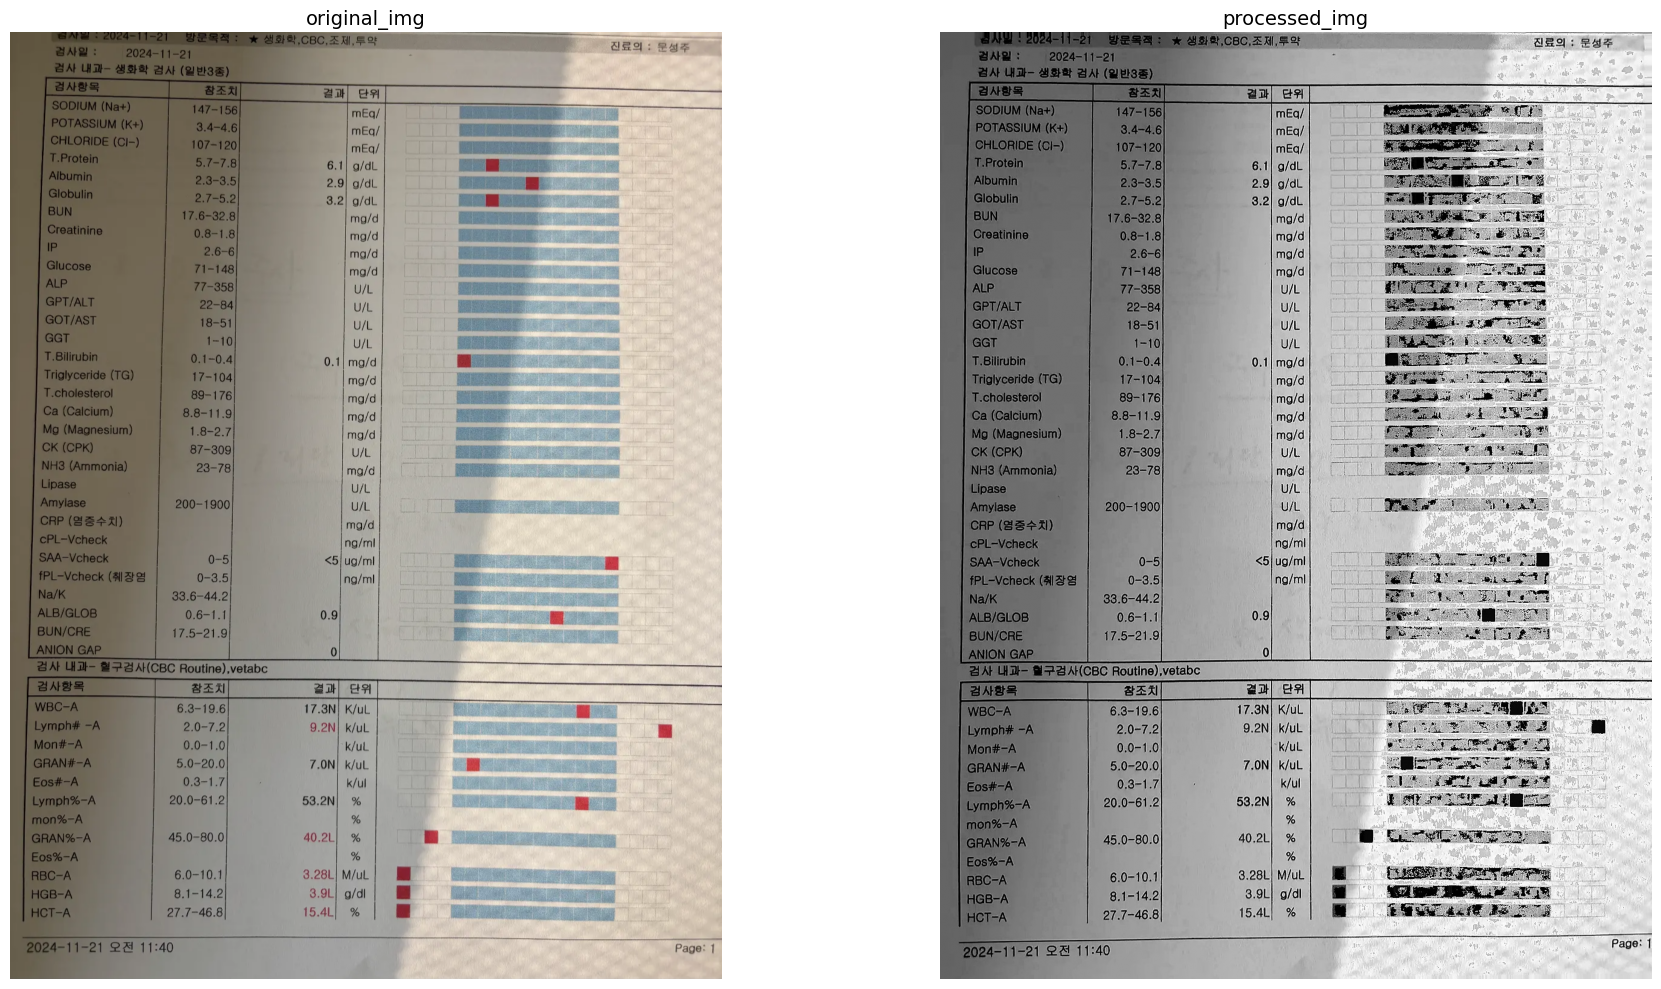

📊 원본: (1179, 1568), 모드: RGBA
📊 처리후: (1353, 1800), 모드: L

🔍 GPT-4V 혈액검사 분석 시작...
🎯 분석 결과:
{
  "tests": [
    {
      "code": "SODIUM (Na+)",
      "value": "UNKNOWN",
      "reference_min": "147",
      "reference_max": "156",
      "unit": "mEq/l"
    },
    {
      "code": "POTASSIUM (K+)",
      "value": "UNKNOWN",
      "reference_min": "3.4",
      "reference_max": "4.6",
      "unit": "mEq/l"
    },
    {
      "code": "CHLORIDE (Cl−)",
      "value": "UNKNOWN",
      "reference_min": "107",
      "reference_max": "120",
      "unit": "mEq/l"
    },
    {
      "code": "T.Protein",
      "value": "6.1",
      "reference_min": "5.7",
      "reference_max": "7.8",
      "unit": "g/dL"
    },
    {
      "code": "Albumin",
      "value": "3.5",
      "reference_min": "2.9",
      "reference_max": "UNKNOWN",
      "unit": "g/dL"
    },
    {
      "code": "Globulin",
      "value": "2.9",
      "reference_min": "2.7",
      "reference_max": "5.2",
      "unit": "g/dL"
    },
    {
   

In [179]:
def runOcrTest():
    print(f"📷 이미지 파일 로드 중: {img_path}")

    # 이미지 파일을 바이트로 읽기
    with open(img_path, 'rb') as f:
        img_data = f.read()

    # 원본 이미지도 표시용으로 로드
    original_img = Image.open(img_path)

    # 전처리 실행
    print("\n🔧 전처리 시작...")
    processed_image_bytes = preprocess(img_data)

    # bytes를 PIL Image로 변환
    processed_img = Image.open(io.BytesIO(processed_image_bytes))

    # 원본과 전처리된 이미지를 함께 표시
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # 원본 이미지
    axes[0].imshow(original_img)
    axes[0].set_title('original_img', fontsize=14)
    axes[0].axis('off')

    # 전처리된 이미지
    if processed_img.mode == 'L':  # 그레이스케일
        axes[1].imshow(processed_img, cmap='gray', vmin=0, vmax=255)
    else:  # 컬러
        axes[1].imshow(processed_img)
    axes[1].set_title('processed_img', fontsize=14)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # 이미지 정보 출력
    print(f"📊 원본: {original_img.size}, 모드: {original_img.mode}")
    print(f"📊 처리후: {processed_img.size}, 모드: {processed_img.mode}")

    analysis_result = []

    # GPT-4V로 의료 문서 분석
    print("\n🔍 GPT-4V 혈액검사 분석 시작...")
    # analysis_result = analyze_medical_document_with_gpt4v(img_data, page_num=0)
    analysis_result = analyze_medical_document_with_gpt4v(processed_image_bytes, page_num=0)  

    # 결과를 깔끔하게 출력
    print("🎯 분석 결과:")
    print(json.dumps(analysis_result, indent=2, ensure_ascii=False))

    return analysis_result

analysis_result = runOcrTest()    

In [180]:
# analysis_result 에서 "value" 가 빈 문자열이 아닌 항목만 필터링
filtered_tests = [test for test in analysis_result.get("tests", []) if test.get("value") not in ("", None)]
analysis_result["tests"] = filtered_tests   

# code 공백 제거 + '-A' 접미 제거
def _clean_str(s: str) -> str:
    return "".join((s or "").split())

for test in analysis_result.get('tests', []):
    # 모든 문자열 필드의 공백문자 제거
    for key in ("code", "value", "unit", "reference_min", "reference_max"):
        if key in test and isinstance(test[key], str):
            test[key] = _clean_str(test[key])
    # '-A' 접미 제거
    if test.get('code', '').endswith('-A'):
        test['code'] = test['code'][:-2]

# 결과를 깔끔하게 출력
print("🎯 분석 결과:")
print(json.dumps(analysis_result, indent=2, ensure_ascii=False))

🎯 분석 결과:
{
  "tests": [
    {
      "code": "SODIUM(Na+)",
      "value": "UNKNOWN",
      "reference_min": "147",
      "reference_max": "156",
      "unit": "mEq/l"
    },
    {
      "code": "POTASSIUM(K+)",
      "value": "UNKNOWN",
      "reference_min": "3.4",
      "reference_max": "4.6",
      "unit": "mEq/l"
    },
    {
      "code": "CHLORIDE(Cl−)",
      "value": "UNKNOWN",
      "reference_min": "107",
      "reference_max": "120",
      "unit": "mEq/l"
    },
    {
      "code": "T.Protein",
      "value": "6.1",
      "reference_min": "5.7",
      "reference_max": "7.8",
      "unit": "g/dL"
    },
    {
      "code": "Albumin",
      "value": "3.5",
      "reference_min": "2.9",
      "reference_max": "UNKNOWN",
      "unit": "g/dL"
    },
    {
      "code": "Globulin",
      "value": "2.9",
      "reference_min": "2.7",
      "reference_max": "5.2",
      "unit": "g/dL"
    },
    {
      "code": "BUN",
      "value": "UNKNOWN",
      "reference_min": "17.6",
      "r

In [181]:
# analysis_result 에서 'code' 항목만 추출하여 리스트로 출력
codes = [test['code'] for test in analysis_result.get('tests', [])]
print("\n📝 추출된 검사 항목 code들:")
print("\n".join(codes))


📝 추출된 검사 항목 code들:
SODIUM(Na+)
POTASSIUM(K+)
CHLORIDE(Cl−)
T.Protein
Albumin
Globulin
BUN
Creatinine
IP
Glucose
ALP
GPT/ALT
GOT/AST
GGT
T.Bilirubin
Tridlyceride(TG)
T.cholesterol
Ca(Calcium)
Mg(Magnesium)
CK(CPK)
NH3(Ammonia)
Lipase
Amylase
CRP(염증수치)
cPL-Vcheck
SAA-Vcheck
fPL-Vcheck(췌장염)
Na/K
ALB/GLOB
BUN/CRE
ANIONGAP
WBC
Lymph#
Mon#
GRAN#
Eos#
Lymph%
Mon%
GRAN%
Eos%
RBC
HGB
HCT


In [182]:
import sys
from pathlib import Path

base_dir = Path("/home/aidan/work/meow-chat/app/services/analysis")
sys.path.append(str(base_dir))

# blood_analyzer.py 모듈의 함수들 사용 
from blood_analyzer import (
    extract_all_unique_codes,
    extract_analyzer_codes,
    extract_subparameter_codes,
    get_analyzer_codes_by_manufacturer,
    get_analyzer_codes_by_model,
    get_subparameter_codes_by_category,
    get_code_statistics,
    search_code_in_data
)

# 1. 전체 unique 코드 추출
all_codes = extract_all_unique_codes()
print(f"1. 전체 unique 코드 개수: {len(all_codes)}개")
print("\n=== 전체 unique 코드 목록 ===")
for code in all_codes:
    print(code)

1. 전체 unique 코드 개수: 152개

=== 전체 unique 코드 목록 ===
AG
ALB
ALB_GLOB
ALKP
ALP
ALT
AMY
AMYL
AST
A_G
A_G(calc)
Albumin
AnGap
BA
BASO
BASO#
BASO%
BASO(%)
BB
BE
BE-Ecf
BIL
BLO
BUN
BUN/CRE
BUN_CREA
Bacteria
CHOL
CHOL_HDL_RATIO
CK
CORT
CPK
CRE
CREA
CRP
Ca
Cl
Cl-
Crystals
EOS
EOS#
EOS%
EOS(%)
FIB
FSAA
FT4
GGT
GLOB
GLOB(calc)
GLU
GRAN#
GRAN%
Globulin
HCO3
HCO3-Std
HCT
HDL_C
HGB
IP
K
K+
KET
LAC
LDH
LDL_C
LYM
LYM#
LYM%
LYMPH
LYMPHO(%)
Lymph#
Lymph%
MCH
MCHC
MCV
MON
MONO
MONO#
MONO%
MPV
Mg
Mono(%)
NEU#
NEU%
NEU(GRA)
NEUT
NEUTROPHILS(%)
NH3
Na
Na+
Na/K
Na_K
O2SAT
PCO2(T)
PCT
PCT%
PDW
PH(T)
PHOS
PLT
PO2(T)
PRO
PT
RBC
RDW
RDW-CV
RDW-SD
RDWc
RETHGB
RETIC
RETIC#
RETIC%
RETIC-HGB
SAA
SG
SNAP BNP
SNAP FIV/FeLV
SNAP T4
SNAP fPL
T.Billirubin
T.Protein
T4
TBIL
TCHO
TCO2
TG
TP
TSH
WBC
WBC-BASO#
WBC-BASO%
WBC-EOS#
WBC-EOS%
WBC-LYM#
WBC-LYM%
WBC-MONO#
WBC-MONO%
WBC-NEU#
WBC-NEU%
aPTT
cPL
fPL
iCa-pH7.4
pCO2
pH
pO2
pO2(A-a)
sO2
tCO2
tHb
v-AMYL
v-LIP


In [183]:
# analysis_result 의 code 항목의 대소문자가 unique 코드 목록에서의 대소문자와 일치하지 않다면 unique 코드 로 교정
def _norm_key(s: str) -> str:
    return ''.join((s or '').split()).casefold()

# unique 코드(정답 표기) 매핑: 정규화키 -> 원본 표기
canonical_map = {_norm_key(c): c for c in all_codes}

changes = []
for t in analysis_result.get("tests", []):
    code = (t.get("code") or "").strip()
    if not code:
        continue
    k = _norm_key(code)
    canon = canonical_map.get(k)
    if canon and code != canon:
        changes.append((code, canon))
        t["code"] = canon

if changes:
    print("🔧 code 교정 내역:")
    for before, after in changes:
        print(f" - {before} -> {after}")
else:
    print("✅ code 대소문자 교정 필요 없음")

🔧 code 교정 내역:
 - Eos# -> EOS#
 - Eos% -> EOS%


In [184]:
# analysis_result 의 code 항목들 중 전체 unique 코드에 포함되지 않은 항목들 출력. 
unknown_codes = [test['code'] for test in analysis_result.get('tests', []) if test['code'] not in all_codes]
if unknown_codes:
    print("\n❓ 알 수 없는 코드들:")
    for code in unknown_codes:
        print(f" {code}")
else:
    print("\n✅ 모든 코드가 알려진 항목입니다.")




❓ 알 수 없는 코드들:
 SODIUM(Na+)
 POTASSIUM(K+)
 CHLORIDE(Cl−)
 Creatinine
 Glucose
 GPT/ALT
 GOT/AST
 T.Bilirubin
 Tridlyceride(TG)
 T.cholesterol
 Ca(Calcium)
 Mg(Magnesium)
 CK(CPK)
 NH3(Ammonia)
 Lipase
 Amylase
 CRP(염증수치)
 cPL-Vcheck
 SAA-Vcheck
 fPL-Vcheck(췌장염)
 ALB/GLOB
 ANIONGAP
 Mon#
 Mon%
